<h1><center>Sales Analysis<center><h1>

<h1><center>Import the required libraries and foundational code</center></h1>

In [258]:
# Load libraries for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings


In [259]:
# This code standardizes illustrations
plt.rcParams['figure.figsize'] = [10,8]
plt.rc('axes', titlesize= 20, labelsize =15)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif' # Example: change font family

In [260]:
# ignores supplemental warnings
warnings.filterwarnings('ignore')

<h1><center>Load data and perform feature engineerig</center></h1>

In [261]:
# Load data and display dataframe.
sales = pd.read_csv('sales_data.csv', 
                    index_col='Sale_Date', 
                    parse_dates=True,
                    dayfirst=True)

sales

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,1010,Charlie,North,4733.88,4,Food,4943.03,5442.15,Returning,0.29,Cash,Online,North-Charlie
2023-09-07,1067,Bob,North,4716.36,37,Clothing,1754.32,1856.40,New,0.21,Bank Transfer,Retail,North-Bob
2023-04-27,1018,David,South,7629.70,17,Clothing,355.72,438.27,Returning,0.06,Bank Transfer,Online,South-David


In [262]:
# Display shape of the data frame.
print("The dimension of the data frame is:", sales.shape)

The dimension of the data frame is: (1000, 13)


In [263]:
# Display data types.
print("The data types in the data frame are:\n", sales.dtypes)

The data types in the data frame are:
 Product_ID                int64
Sales_Rep                object
Region                   object
Sales_Amount            float64
Quantity_Sold             int64
Product_Category         object
Unit_Cost               float64
Unit_Price              float64
Customer_Type            object
Discount                float64
Payment_Method           object
Sales_Channel            object
Region_and_Sales_Rep     object
dtype: object


In [264]:
# Create a new data frame called sales_t.
sales_t = sales
sales_t.head()

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [265]:
# Drop redundant column
sales_t.drop(columns='Region_and_Sales_Rep', inplace=True)

In [266]:
# Create a new column to display the net price of the products
sales_t['Net_Price'] = sales_t['Unit_Price']-sales_t['Discount']

In [267]:
# Found a discrepency in Sales Amount column and recalculated based 
# on net price and quantity sold.
sales_t['Profit'] = sales_t['Net_Price'] * sales_t['Quantity_Sold']

In [268]:
# Created a total cost column.
sales_t['Total_Cost']= sales_t['Unit_Cost'] * sales_t['Quantity_Sold']

In [269]:
# Drop sales amount column 
sales_t = sales_t.drop(columns='Sales_Amount')

In [270]:
# Sort index 
sales_t = sales_t.sort_index()

In [271]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [272]:
# Display dataframe with new features.
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


In [273]:
sales_t.tail()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-12-31,1090,Eve,West,46,Clothing,4665.12,4675.90,New,0.19,Cash,Retail,4675.71,215082.66,214595.52
2023-12-31,1094,Bob,South,15,Food,4111.93,4338.67,Returning,0.26,Credit Card,Online,4338.41,65076.15,61678.95
2024-01-01,1018,Alice,West,24,Electronics,1362.78,1729.81,New,0.29,Bank Transfer,Online,1729.52,41508.48,32706.72
2024-01-01,1098,Bob,South,11,Clothing,213.41,503.36,Returning,0.27,Bank Transfer,Online,503.09,5533.99,2347.51
2024-01-01,1078,David,East,42,Food,63.41,314.93,Returning,0.03,Cash,Retail,314.90,13225.80,2663.22


In [274]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [275]:
salesOne_hot_encoding = pd.get_dummies(sales_t).replace({True:1, False:0})

In [276]:
salesOne_hot_encoding.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
Sale_Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1070,12,664.33,863.03,0.25,862.78,10353.36,7971.96,0,0,...,0,0,1,0,1,1,0,0,0,1
2023-01-01,1089,35,4071.01,4304.70,0.14,4304.56,150659.60,142485.35,0,0,...,0,0,0,1,0,0,0,1,1,0
2023-01-01,1008,38,4635.23,5075.44,0.05,5075.39,192864.82,176138.74,0,0,...,0,0,0,0,1,0,1,0,1,0
2023-01-02,1064,10,2242.01,2282.23,0.20,2282.03,22820.30,22420.10,0,0,...,1,0,0,0,1,0,0,1,1,0
2023-01-02,1075,26,4535.38,4557.56,0.00,4557.56,118496.56,117919.88,0,0,...,1,0,0,1,0,0,0,1,1,0


In [277]:
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


<h1><center> Visualize data to find seasonality and trends </center></h1>

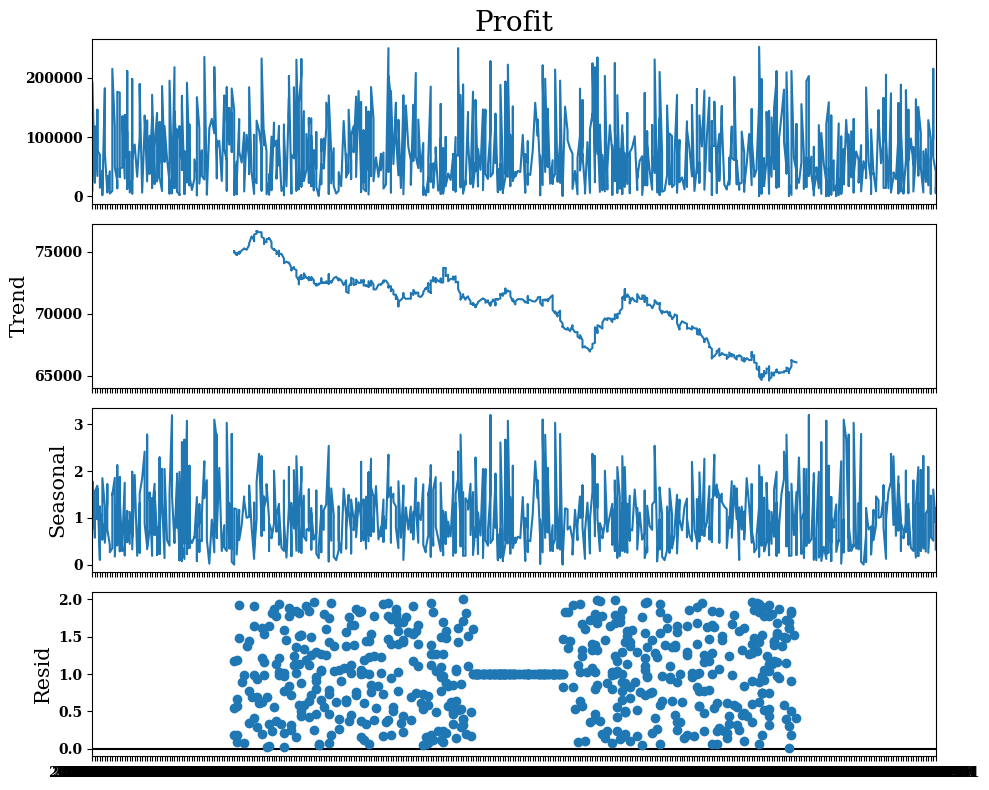

In [278]:
# Check profit for seasonality.
decomposition = seasonal_decompose(sales_t['Profit'],
                                   model ='mul',
                                   period=365)
fig= decomposition.plot()
plt.show()

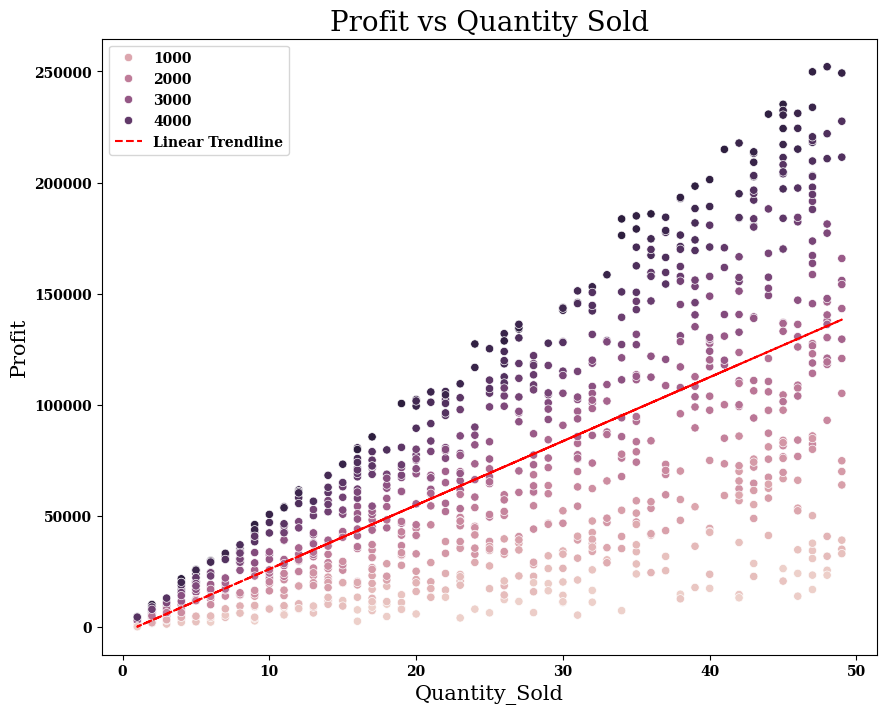

In [279]:
# scatter plot showing a positive trend with profit and quantity sold.
sns.scatterplot(data=salesOne_hot_encoding, x='Quantity_Sold', y='Profit', hue='Unit_Cost')
z = np.polyfit(salesOne_hot_encoding['Quantity_Sold'], salesOne_hot_encoding['Profit'], 1)
p = np.poly1d(z)
plt.plot(salesOne_hot_encoding['Quantity_Sold'], p(salesOne_hot_encoding['Quantity_Sold']), "r--", label="Linear Trendline")
plt.title('Profit vs Quantity Sold')
plt.legend()
plt.show()

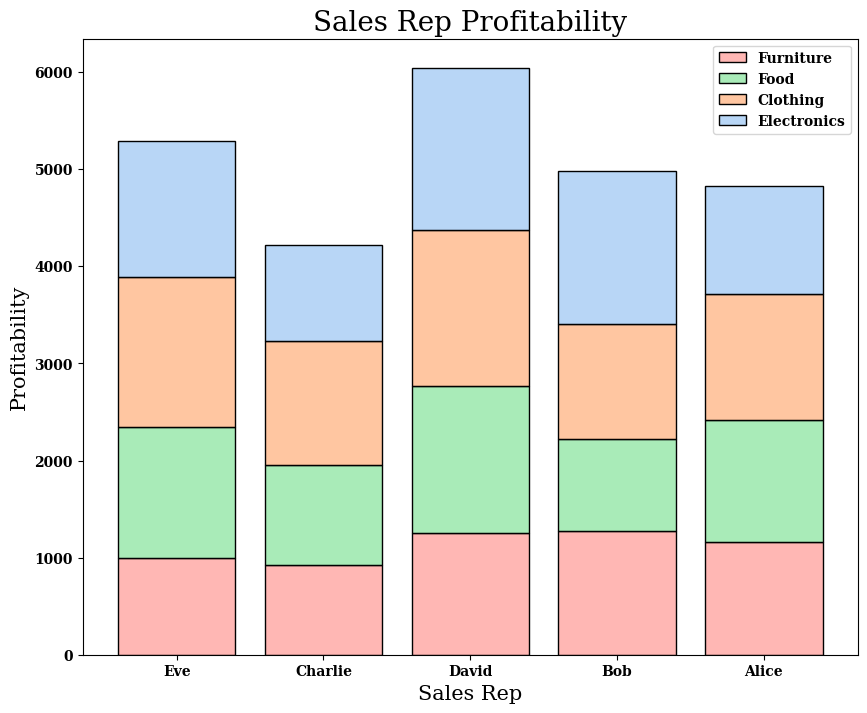

In [280]:
# Stacked barplot outlining the products sold by sales rep.
color_map = ('Furniture', 'Food', 'Clothing', 'Electronics')
sns.histplot(data=sales_t, x='Sales_Rep',weights='Quantity_Sold', 
             hue='Product_Category', multiple='stack',shrink=0.8, palette='pastel')
plt.title('Sales Rep Profitability')
plt.xlabel('Sales Rep')
plt.ylabel('Profitability')
plt.legend(color_map)
plt.show()

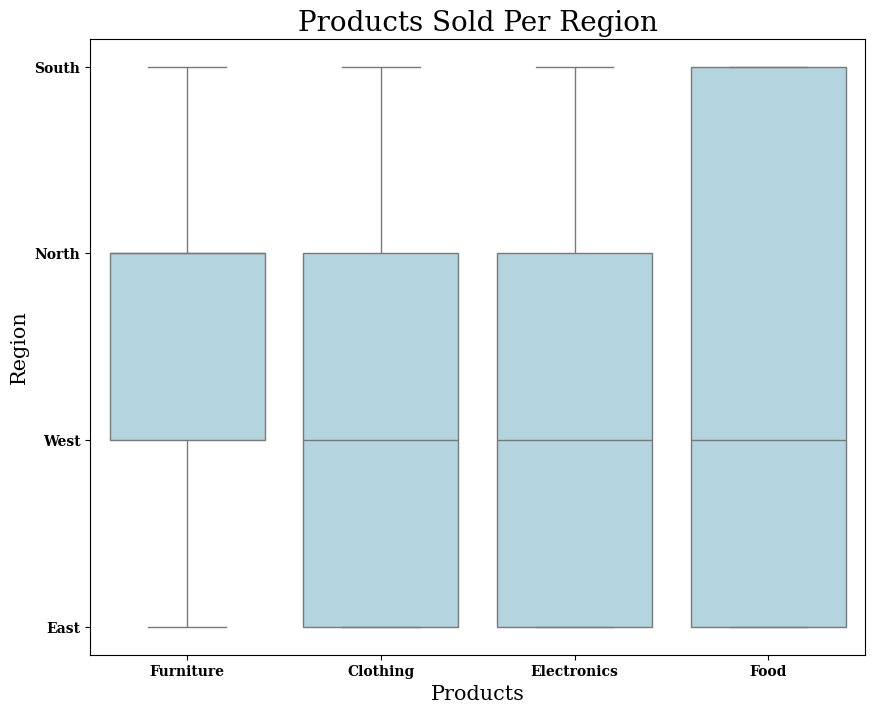

In [281]:
# box plot to compare products sold per region.
sns.boxplot(data=sales_t, x='Product_Category', y= 'Region', color='lightblue')
plt.title('Products Sold Per Region')
plt.xlabel('Products')
plt.ylabel('Region')
plt.show()

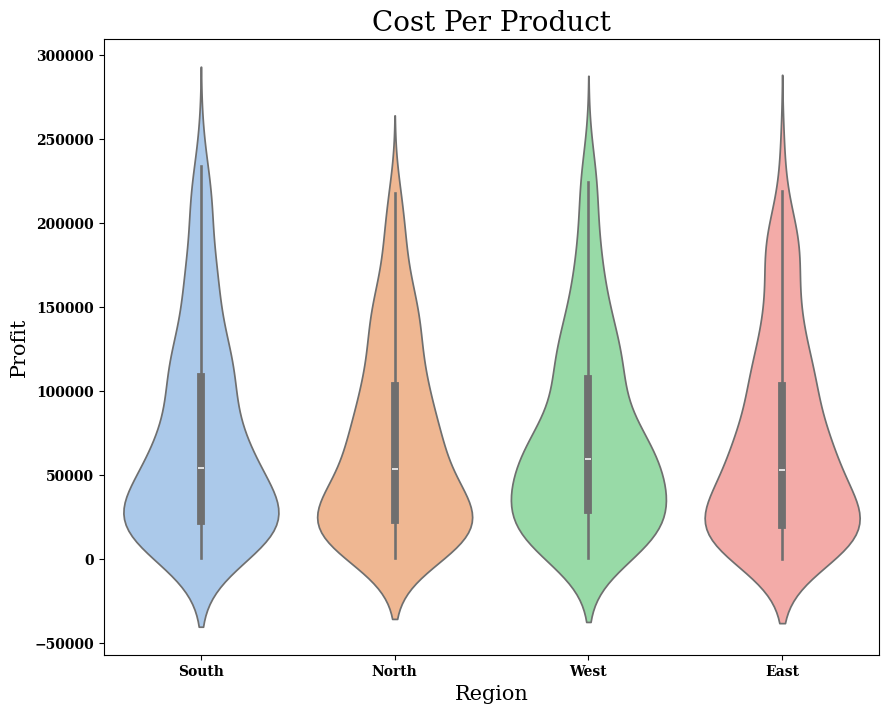

In [282]:
sns.violinplot(data=sales_t, x='Region', y='Profit', palette='pastel')
plt.title('Cost Per Product')
plt.xlabel('Region')
plt.ylabel('Profit')

plt.show()


In [283]:
result =adfuller(sales_t.Profit)
print('p-value: %f' % result[1])

if result[1]<0.5:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary")

p-value: 0.000000
Evidence suggests that the time series is stationary.


In [284]:
# Split data into a train and test set.
test_days = 120
train, test = sales_t.iloc[:-test_days], sales_t.iloc[-test_days:]
test

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-11-19,1033,David,North,37,Electronics,2600.76,2937.57,New,0.17,Credit Card,Retail,2937.40,108683.80,96228.12
2023-11-19,1045,Bob,North,2,Electronics,912.08,993.24,Returning,0.09,Credit Card,Online,993.15,1986.30,1824.16
2023-11-20,1036,Alice,East,32,Clothing,700.49,1126.52,New,0.29,Credit Card,Retail,1126.23,36039.36,22415.68
2023-11-20,1012,Bob,North,1,Food,4190.83,4528.77,Returning,0.22,Bank Transfer,Online,4528.55,4528.55,4190.83
2023-11-20,1084,Bob,South,15,Furniture,3420.72,3513.74,New,0.02,Cash,Online,3513.72,52705.80,51310.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,1090,Eve,West,46,Clothing,4665.12,4675.90,New,0.19,Cash,Retail,4675.71,215082.66,214595.52
2023-12-31,1094,Bob,South,15,Food,4111.93,4338.67,Returning,0.26,Credit Card,Online,4338.41,65076.15,61678.95
2024-01-01,1018,Alice,West,24,Electronics,1362.78,1729.81,New,0.29,Bank Transfer,Online,1729.52,41508.48,32706.72


In [285]:
model = auto_arima(train['Profit'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  880
Model:                        SARIMAX   Log Likelihood              -10908.707
Date:                Thu, 25 Sep 2025   AIC                          21821.414
Time:                        07:39:54   BIC                          21830.974
Sample:                             0   HQIC                         21825.070
                                - 880                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    7.08e+04   2615.003     27.076      0.000    6.57e+04    7.59e+04
sigma2      3.426e+09   2.15e+08     15.909      0.000       3e+09    3.85e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               127.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.93
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
predictions_arima= model.predict(n_periods = len(test))
predictions_arima

880    70802.867807
881    70802.867807
882    70802.867807
883    70802.867807
884    70802.867807
           ...     
995    70802.867807
996    70802.867807
997    70802.867807
998    70802.867807
999    70802.867807
Length: 120, dtype: float64